In [1]:
# Bibliotheken
import pandas as pd
import numpy as np
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Daten laden
df = pd.read_csv('../data/processed/china_model_dataset.csv')

# Rolling Average (optional zur Glättung)
df_rolling = df.copy()
rolling_cols = [col for col in df.columns if col != 'Year']
df_rolling[rolling_cols] = df_rolling[rolling_cols].rolling(window=3, min_periods=1).mean()

# Lag-Features
df_rolling['GDP_lag1'] = df_rolling['GDP'].shift(1)
df_rolling['Energy_intensity_lag1'] = df_rolling['Energy_intensity'].shift(1)

# Drop NaNs
df_rolling = df_rolling.dropna().reset_index(drop=True)

# Features
features = [
    'Primary_energy', 'Energy_intensity', 'Population', 'GDP',
    'Urban_population_pct', 'Trade_share_GDP', 'GDP_growth_annual',
    'GDP_lag1', 'Energy_intensity_lag1'
]

# Targets: einzelne CO₂-Komponenten
targets = ['CO2_coal', 'CO2_oil', 'CO2_gas', 'CO2_cement']

# Aufteilen in Trainings- und Testdaten
train = df_rolling[df_rolling['Year'] <= 2010]
test = df_rolling[df_rolling['Year'] > 2010]

X_train = train[features]
y_train = train[targets]
X_test = test[features]
y_test = test[targets]

# Multi-Output Modell
base_model = RandomForestRegressor(n_estimators=100, random_state=42)
model = MultiOutputRegressor(base_model)
model.fit(X_train, y_train)

# Vorhersage
y_pred = model.predict(X_test)
y_pred_df = pd.DataFrame(y_pred, columns=targets)
y_pred_df['Year'] = test['Year'].values
y_pred_df['CO2_total'] = y_pred_df.sum(axis=1)

# Vergleichstabelle
vergleich = test[['Year']].copy()
vergleich[['CO2_coal', 'CO2_oil', 'CO2_gas', 'CO2_cement']] = y_test.values
vergleich[['Pred_coal', 'Pred_oil', 'Pred_gas', 'Pred_cement']] = y_pred
vergleich['Tatsächlich_CO2'] = y_test.sum(axis=1).values
vergleich['Prognose_CO2'] = y_pred_df['CO2_total'].values
vergleich['Genauigkeit_%'] = 100 - (abs(vergleich['Prognose_CO2'] - vergleich['Tatsächlich_CO2']) / vergleich['Tatsächlich_CO2'] * 100)
vergleich['Genauigkeit_%'] = vergleich['Genauigkeit_%'].round(2)

# Metriken
rmse = np.sqrt(mean_squared_error(vergleich['Tatsächlich_CO2'], vergleich['Prognose_CO2']))
mae = mean_absolute_error(vergleich['Tatsächlich_CO2'], vergleich['Prognose_CO2'])
r2 = r2_score(vergleich['Tatsächlich_CO2'], vergleich['Prognose_CO2'])

print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R²-Score:", r2)

Root Mean Squared Error (RMSE): 1202.009660307407
Mean Absolute Error (MAE): 1091.8235223809502
R²-Score: -7.20308571012886


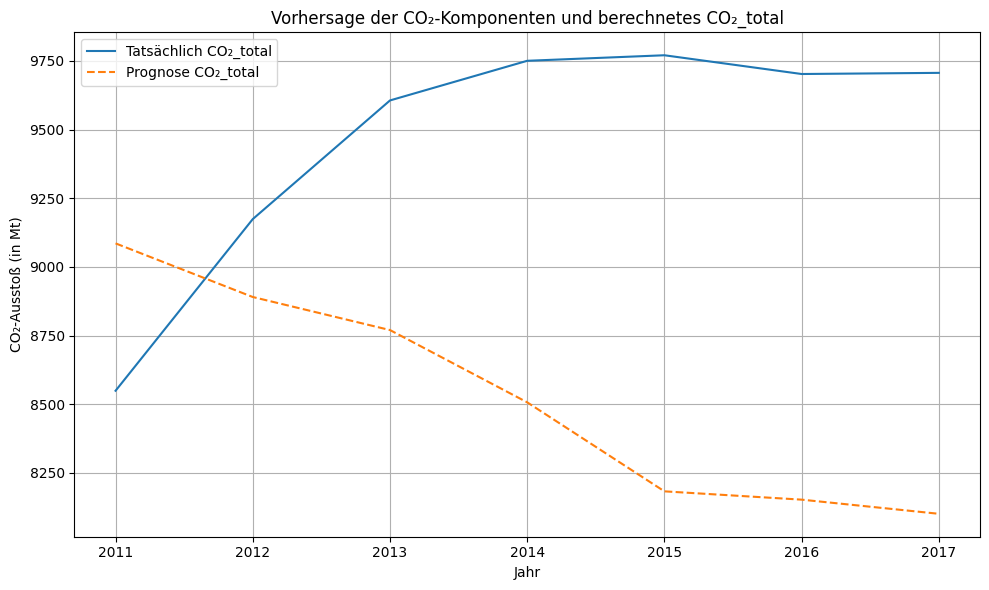

    Year  Tatsächlich_CO2  Prognose_CO2  Genauigkeit_%
45  2011      8549.138000   9085.705653          93.72
46  2012      9174.150000   8890.454093          96.91
47  2013      9606.146000   8770.087280          91.30
48  2014      9750.473333   8506.967227          87.25
49  2015      9770.639667   8182.877587          83.75
50  2016      9702.378333   8152.632057          84.03
51  2017      9706.557000   8101.129087          83.46


In [2]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(vergleich['Year'], vergleich['Tatsächlich_CO2'], label='Tatsächlich CO₂_total')
plt.plot(vergleich['Year'], vergleich['Prognose_CO2'], label='Prognose CO₂_total', linestyle='--')
plt.xlabel('Jahr')
plt.ylabel('CO₂-Ausstoß (in Mt)')
plt.title('Vorhersage der CO₂-Komponenten und berechnetes CO₂_total')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Vergleichstabelle anzeigen
print(vergleich[['Year', 'Tatsächlich_CO2', 'Prognose_CO2', 'Genauigkeit_%']])

In [3]:
## Prognose-Modell bis 2050

In [4]:
# Zeitraum 2013–2017 extrahieren
trend_df = df[(df['Year'] >= 2013) & (df['Year'] <= 2017)].reset_index(drop=True)

# Spalten, für die die Wachstumsrate berechnet werden soll
columns_to_analyze = [
    'GDP', 'Population', 'Primary_energy', 'Energy_intensity',
    'CO2_coal', 'CO2_oil', 'CO2_gas', 'CO2_cement',
    'Urban_population_pct', 'Trade_share_GDP', 'GDP_growth_annual'
]

# Wachstumsraten berechnen
trend_results = []
for col in columns_to_analyze:
    start_value = trend_df.iloc[0][col]
    end_value = trend_df.iloc[-1][col]
    n_years = trend_df.iloc[-1]['Year'] - trend_df.iloc[0]['Year']
    growth_rate = (end_value / start_value) ** (1 / n_years) - 1
    trend_results.append({
        'Feature': col,
        'Startwert': start_value,
        'Endwert': end_value,
        'Jahreswachstum': growth_rate
    })

# In DataFrame umwandeln und runden
trend_table = pd.DataFrame(trend_results)
trend_table['Jahreswachstum'] = (trend_table['Jahreswachstum'] * 100).round(3)  # in Prozent
trend_table = trend_table.round(2)

# Tabelle anzeigen
print(trend_table)

# Wachstumsraten als Dictionary (dezimal)
growth = dict(zip(trend_table['Feature'], (trend_table['Jahreswachstum'] / 100).values))

                 Feature     Startwert       Endwert  Jahreswachstum
0                    GDP  1.592546e+13  2.089436e+13            7.02
1             Population  1.379008e+09  1.412355e+09            0.60
2         Primary_energy  3.385256e+04  3.664938e+04            2.00
3       Energy_intensity  2.130000e+00  1.750000e+00           -4.70
4               CO2_coal  7.493410e+03  7.163260e+03           -1.12
5                CO2_oil  1.234620e+03  1.430590e+03            3.75
6                CO2_gas  3.201300e+02  4.863600e+02           11.02
7             CO2_cement  7.483200e+02  7.534400e+02            0.17
8   Urban_population_pct  5.301000e+01  5.796000e+01            2.26
9        Trade_share_GDP  4.657000e+01  3.780000e+01           -5.08
10     GDP_growth_annual  7.760000e+00  6.900000e+00           -2.89


In [5]:
import os

# Zieljahre für die Prognose
future_years = list(range(2018, 2051))

# Letzter bekannter Jahrgang als Startpunkt
last_row = df[df['Year'] == 2017].iloc[0]

# Wachstumsraten aus 2013–2017 in Dezimalform
growth = {
    'GDP': 0.0702,
    'Population': 0.0060,
    'Primary_energy': 0.0200,
    'Energy_intensity': -0.0470,
    'CO2_coal': -0.0112,
    'CO2_oil': 0.0375,
    'CO2_gas': 0.1102,
    'CO2_cement': 0.0017,
    'Urban_population_pct': 0.0226,
    'Trade_share_GDP': -0.0508,
    'GDP_growth_annual': -0.0289
}

# BAU- und Maßnahmen-Szenario initialisieren mit Jahr 2017
bau = last_row.copy()
measures = last_row.copy()

# Ergebnislisten
bau_rows = []
measure_rows = []

# Szenarien berechnen
for year in future_years:
    row_bau = bau.copy()
    row_mea = measures.copy()
    
    row_bau['Year'] = year
    row_mea['Year'] = year

    # Normales Wachstum (Basis)
    for key in growth:
        row_bau[key] *= (1 + growth[key])
        row_mea[key] *= (1 + growth[key])

    # Maßnahmen-Szenario (B) – gezielte Eingriffe
    if year >= 2018:
        row_mea['CO2_coal'] *= (1 - 0.02)

    if year >= 2025:
        row_mea['CO2_oil'] *= (1 - 0.015)
        base_energy_intensity = row_mea['Energy_intensity'] / (1 + growth['Energy_intensity'])
        row_mea['Energy_intensity'] = base_energy_intensity * (1 - 0.06)
        base_cement = row_mea['CO2_cement'] / (1 + growth['CO2_cement'])
        row_mea['CO2_cement'] = base_cement * (1 - 0.005)

    if year >= 2030:
        base_gas = row_mea['CO2_gas'] / (1 + growth['CO2_gas'])
        row_mea['CO2_gas'] = base_gas * (1 + 0.005)

    # CO2_total manuell berechnen
    row_bau['CO2_total'] = row_bau['CO2_coal'] + row_bau['CO2_oil'] + row_bau['CO2_gas'] + row_bau['CO2_cement']
    row_mea['CO2_total'] = row_mea['CO2_coal'] + row_mea['CO2_oil'] + row_mea['CO2_gas'] + row_mea['CO2_cement']

    bau_rows.append(row_bau.copy())
    measure_rows.append(row_mea.copy())

    bau = row_bau.copy()
    measures = row_mea.copy()

# In DataFrames umwandeln
future_bau = pd.DataFrame(bau_rows)
future_measures = pd.DataFrame(measure_rows)

# Übersicht zur Kontrolle
print(" Szenario A – Business as Usual (BAU):")
print(f"- Jahre: {future_bau['Year'].min()} bis {future_bau['Year'].max()} | Zeilen: {len(future_bau)}")
print("CO2_total 2050 (BAU):", round(future_bau[future_bau['Year'] == 2050]['CO2_total'].values[0], 2))

print("\n Szenario B – Maßnahmen:")
print(f"- Jahre: {future_measures['Year'].min()} bis {future_measures['Year'].max()} | Zeilen: {len(future_measures)}")
print("CO2_total 2050 (Maßnahmen):", round(future_measures[future_measures['Year'] == 2050]['CO2_total'].values[0], 2))

print("\n Vorschau BAU (2048–2050):")
print(future_bau[['Year', 'CO2_total', 'CO2_coal', 'CO2_oil', 'CO2_gas', 'CO2_cement']].tail(40))

print("\n Vorschau Maßnahmen (2048–2050):")
print(future_measures[['Year', 'CO2_total', 'CO2_coal', 'CO2_oil', 'CO2_gas', 'CO2_cement']].tail(40))

# Ergebnisordner erstellen und speichern
output_folder = '../data/results/szenario_prognose_china_rf/'
os.makedirs(output_folder, exist_ok=True)

future_bau.to_csv(os.path.join(output_folder, 'china_bau.csv'), index=False)
future_measures.to_csv(os.path.join(output_folder, 'china_measures.csv'), index=False)

print(f"\n Prognosedateien gespeichert in: {output_folder}")

 Szenario A – Business as Usual (BAU):
- Jahre: 2018.0 bis 2050.0 | Zeilen: 33
CO2_total 2050 (BAU): 25875.11

 Szenario B – Maßnahmen:
- Jahre: 2018.0 bis 2050.0 | Zeilen: 33
CO2_total 2050 (Maßnahmen): 8353.11

 Vorschau BAU (2048–2050):
      Year     CO2_total     CO2_coal      CO2_oil       CO2_gas  CO2_cement
52  2018.0   9861.936165  7083.026544  1484.234013    539.955762  754.719846
52  2019.0   9899.051191  7003.696647  1539.892788    599.458887  756.002870
52  2020.0   9945.701343  6925.255244  1597.638768    665.519256  757.288075
52  2021.0  10002.677550  6847.692386  1657.550221    738.859478  758.575465
52  2022.0  10070.853421  6770.998231  1719.708355    820.281793  759.865043
52  2023.0  10151.194128  6695.163051  1784.197418    910.676846  761.156814
52  2024.0  10244.766260  6620.177224  1851.104821   1011.033435  762.450780
52  2025.0  10352.748757  6546.031240  1920.521252   1122.449319  763.746946
52  2026.0  10476.445039  6472.715690  1992.540799   1246.143234  7

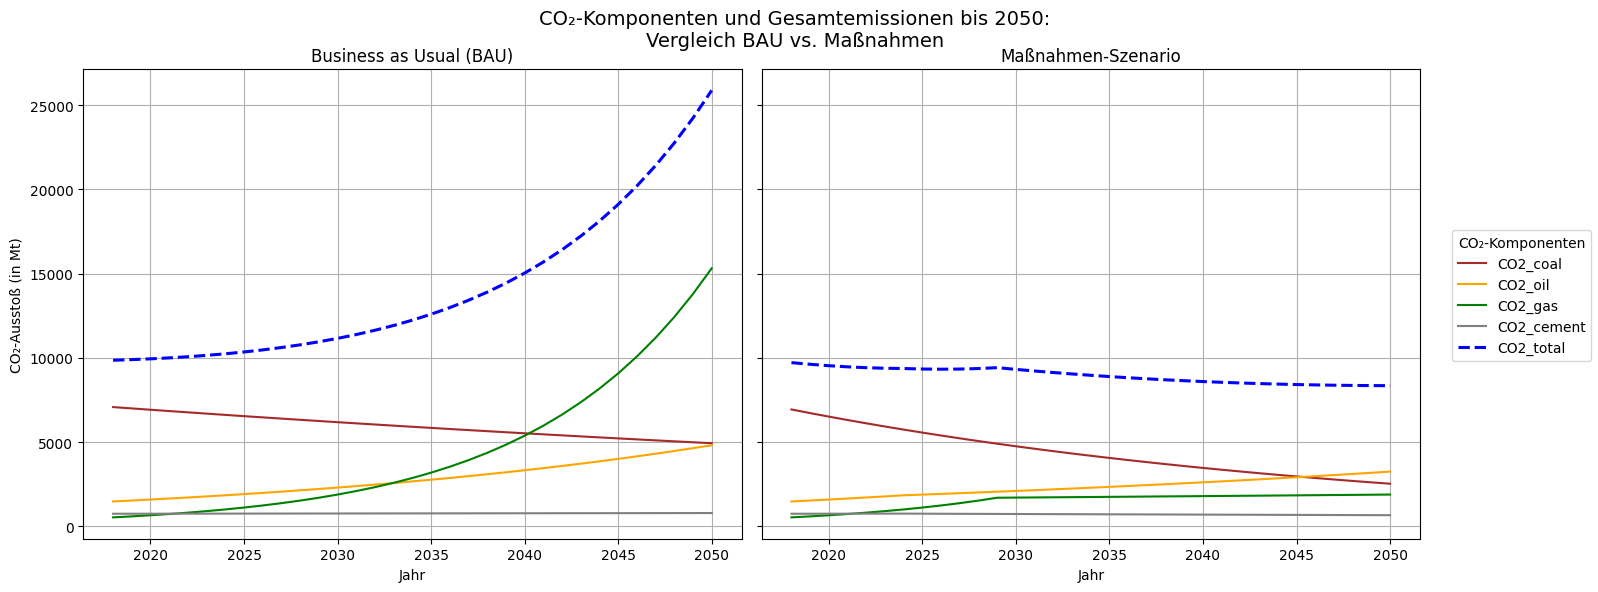

In [6]:
# Farben für CO₂-Komponenten
farben = {
    'CO2_coal': 'brown',
    'CO2_oil': 'orange',
    'CO2_gas': 'green',
    'CO2_cement': 'gray',
    'CO2_total': 'blue'
}

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot 1: BAU
for col in ['CO2_coal', 'CO2_oil', 'CO2_gas', 'CO2_cement']:
    axes[0].plot(future_bau['Year'], future_bau[col], label=col, color=farben[col])
axes[0].plot(
    future_bau['Year'], future_bau['CO2_total'],
    label='CO2_total', color=farben['CO2_total'], linestyle='--', linewidth=2.2
)
axes[0].set_title('Business as Usual (BAU)')
axes[0].set_xlabel('Jahr')
axes[0].set_ylabel('CO₂-Ausstoß (in Mt)')
axes[0].grid(True)

# Plot 2: Maßnahmen
for col in ['CO2_coal', 'CO2_oil', 'CO2_gas', 'CO2_cement']:
    axes[1].plot(future_measures['Year'], future_measures[col], label=col, color=farben[col])
axes[1].plot(
    future_measures['Year'], future_measures['CO2_total'],
    label='CO2_total', color=farben['CO2_total'], linestyle='--', linewidth=2.2
)
axes[1].set_title('Maßnahmen-Szenario')
axes[1].set_xlabel('Jahr')
axes[1].grid(True)

# Legende am rechten rand
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', title='CO₂-Komponenten', fontsize=10)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.suptitle('CO₂-Komponenten und Gesamtemissionen bis 2050:\nVergleich BAU vs. Maßnahmen', fontsize=14)
plt.subplots_adjust(top=0.88)

plt.show()